## $k$-Nearest Neighbor (kNN)
This kNN classifier implementation is a very crude classifier for image classification. It consists of the following components.

### Training:
* Takes the training data and simply stores it

### Prediction:
* Compares the input image to all stored training images and uses the most common label among the $k$ most similar training examples as prediction

In [7]:
# Run some setup code for this notebook.

import random
import numpy as np
from implementation.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
# Load the raw CIFAR-10 data.
cifar10_dir = '../datasets/cifar-10-batches-py'

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Clear previously loaded data.
Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


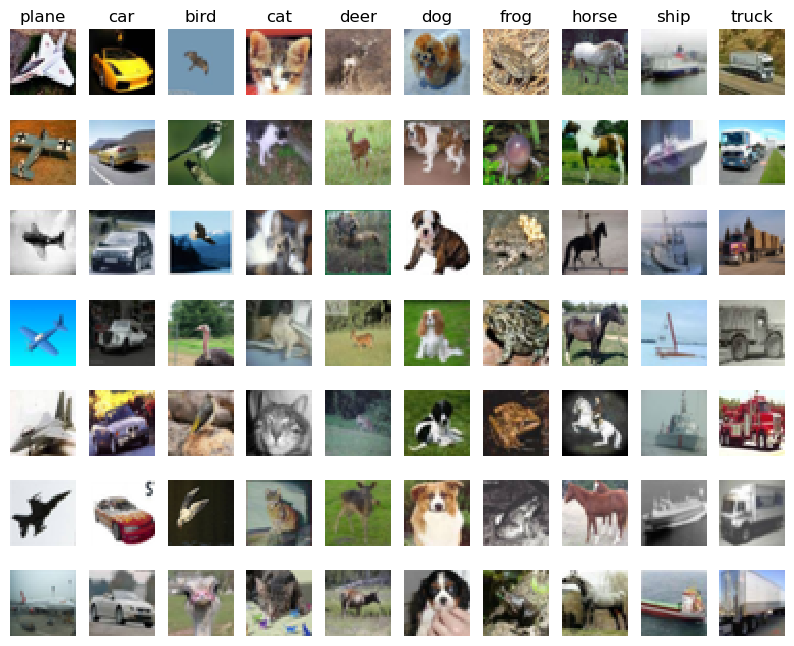

In [9]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [10]:
# Subsample the data for more efficient code execution in this exercise
num_training = 5000
mask = list(range(num_training))
X_train = X_train[mask]
y_train = y_train[mask]

num_test = 500
mask = list(range(num_test))
X_test = X_test[mask]
y_test = y_test[mask]

# Reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
print(X_train.shape, X_test.shape)

(5000, 3072) (500, 3072)


We would now like to classify the test data with the kNN classifier. We can break down this process into two steps: 

1. First we must compute the distances between all test examples and all train examples. 
2. Given these distances, for each test example we find the k nearest examples and have them vote for the label

The function `classifier.compute_distances_no_loops` performs the distance computations using vectorized numpy operations for high efficiency. The labelling is performed by calling `classifier.predict`, which further calls `classifier.predict_labels`.

In [24]:
from implementation.classifiers import KNearestNeighbor
classifier = KNearestNeighbor()

classifier.train(X_train, y_train)

y_preds = classifier.predict(X_test, 5) # k == 5 in this example

# accuracy == number of correct predictions / total number of predictions
accuracy = float(np.sum([y_preds == y_test])) / y_test.size

print('k = %d, accuracy = %f' % (5, accuracy))

k = 5, accuracy = 0.278000


### Cross-validation

We have implemented the k-Nearest Neighbor classifier but we set the value k = 5 arbitrarily. We will now determine the best value of this hyperparameter with cross-validation.

In [25]:
num_folds = 5
k_choices = [1, 3, 5, 8, 10, 12, 15, 20, 50, 100]

X_train_folds = []
y_train_folds = []
"""
Split up the training data into folds. After splitting, X_train_folds and 
y_train_folds are each lists of length num_folds, where y_train_folds[i] is the 
label vector for the points in X_train_folds[i].
"""
X_train_folds = np.array_split(X_train,num_folds)
y_train_folds = np.array_split(y_train,num_folds)

"""
A dictionary holding the accuracies for different values of k that we find
when running cross-validation. After running cross-validation,
k_to_accuracies[k] should be a list of length num_folds giving the different
accuracy values that we found when using that value of k.
"""
k_to_accuracies = {}

"""
Perform k-fold cross validation to find the best value of k:
  - For each possible value of k, run the k-nearest-neighbor algorithm num_folds times, where in each case we use all but one of the folds as training data and the last fold as a validation set.
  - Store the accuracies for all fold and all values of k in the k_to_accuracies dictionary.
"""

for k in k_choices:
  k_accuracies = []
  for fold in range(num_folds):
    # validation data
    X_val = X_train_folds[fold]
    y_val = y_train_folds[fold]
    # training data
    temp_X_train = np.concatenate(X_train_folds[:fold] + X_train_folds[fold+1:])
    temp_y_train = np.concatenate(y_train_folds[:fold] + y_train_folds[fold+1:])

    # train classifier and generate predictions
    classifier.train(temp_X_train, temp_y_train)
    y_val_preds = classifier.predict(X_val, k)
    
    # accuracy
    accuracy = float(np.sum([y_val_preds == y_val])) / y_val.size
    k_accuracies.append(accuracy)
  k_to_accuracies.update({k: k_accuracies})

# Print out the computed accuracies
for k in sorted(k_to_accuracies):
    for accuracy in k_to_accuracies[k]:
        print('k = %d, accuracy = %f' % (k, accuracy))

k = 1, accuracy = 0.263000
k = 1, accuracy = 0.257000
k = 1, accuracy = 0.264000
k = 1, accuracy = 0.278000
k = 1, accuracy = 0.266000
k = 3, accuracy = 0.239000
k = 3, accuracy = 0.249000
k = 3, accuracy = 0.240000
k = 3, accuracy = 0.266000
k = 3, accuracy = 0.254000
k = 5, accuracy = 0.248000
k = 5, accuracy = 0.266000
k = 5, accuracy = 0.280000
k = 5, accuracy = 0.292000
k = 5, accuracy = 0.280000
k = 8, accuracy = 0.262000
k = 8, accuracy = 0.282000
k = 8, accuracy = 0.273000
k = 8, accuracy = 0.290000
k = 8, accuracy = 0.273000
k = 10, accuracy = 0.265000
k = 10, accuracy = 0.296000
k = 10, accuracy = 0.276000
k = 10, accuracy = 0.284000
k = 10, accuracy = 0.280000
k = 12, accuracy = 0.260000
k = 12, accuracy = 0.295000
k = 12, accuracy = 0.279000
k = 12, accuracy = 0.283000
k = 12, accuracy = 0.280000
k = 15, accuracy = 0.252000
k = 15, accuracy = 0.289000
k = 15, accuracy = 0.278000
k = 15, accuracy = 0.282000
k = 15, accuracy = 0.274000
k = 20, accuracy = 0.270000
k = 20, accu

We now plot our accuracy values for each k to determine visually which k leads to the best accuracy.

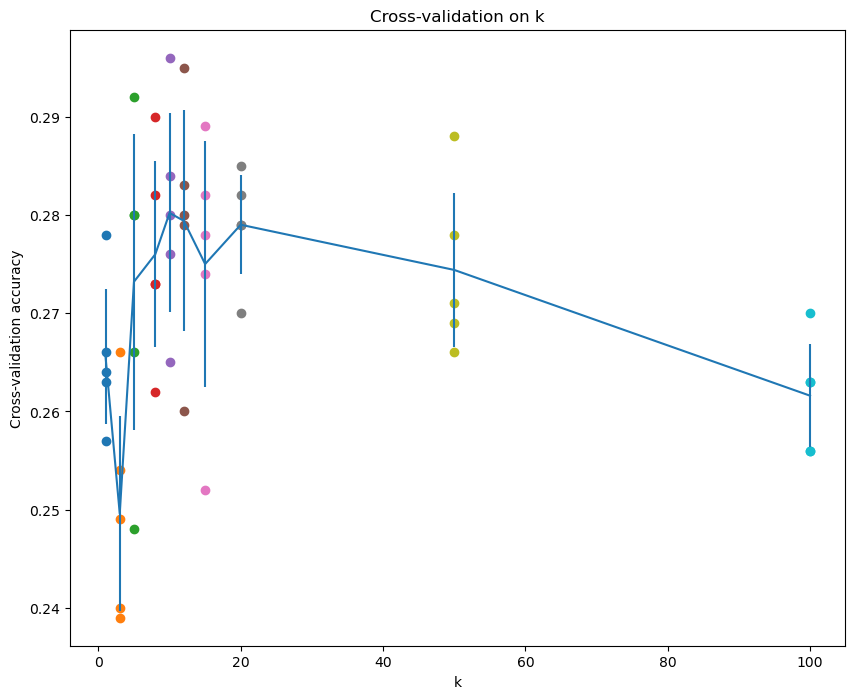

In [26]:
# plot the raw observations
for k in k_choices:
    accuracies = k_to_accuracies[k]
    plt.scatter([k] * len(accuracies), accuracies)

# plot the trend line with error bars that correspond to standard deviation
accuracies_mean = np.array([np.mean(v) for k,v in sorted(k_to_accuracies.items())])
accuracies_std = np.array([np.std(v) for k,v in sorted(k_to_accuracies.items())])
plt.errorbar(k_choices, accuracies_mean, yerr=accuracies_std)
plt.title('Cross-validation on k')
plt.xlabel('k')
plt.ylabel('Cross-validation accuracy')
plt.show()

In [27]:
"""
Based on the above cross-validation, k = 10 is a good candidate for improving the value of the model.
"""
best_k = 10

classifier = KNearestNeighbor()
classifier.train(X_train, y_train)
y_test_pred = classifier.predict(X_test, k=best_k)

# Compute and display the accuracy
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 141 / 500 correct => accuracy: 0.282000
